In [2]:
import numpy as np
import gym
import os

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

import strategically_timed_attack

In [3]:
# Load model
current_dir = os.getcwd()
save_dir = os.path.abspath(os.path.join(current_dir, os.pardir)) + "/ppo/models/"
model = PPO.load(save_dir + "/cartpole-v1/cartpole_v1_ppo_5000")

In [4]:
# Set environment
env = gym.make('CartPole-v1')

In [ ]:
# Test different beta
beta_data = {
    'beta': [],
    'mean_reward': [],
    'mean_perturbation': [],
    'mean_attacks': []
}

for j in range(100):
    num_episodes = 100
    all_episodes_rewards = []
    all_episodes_perturbation = []
    all_episodes_attacks = []

    for i in range(num_episodes):
        episode_rewards = []
        episode_perturbations = []
        episode_attacks = []
        done = False
        obs = env.reset()

        timestep = 0

        beta = j / 100
        
        while not done:

            timestep += 1

            ### strategically timed attack ###
            adversarial_sample, total_perturbation, attacked = strategically_timed_attack.perturb(env, obs, (0.0, 0.0, 0.5, 0.5), beta)
            ### strategically timed attack ###        
            
            action, _states = model.predict(adversarial_sample)
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            episode_perturbations.append(total_perturbation)
            episode_attacks.append(attacked)

        all_episodes_rewards.append(sum(episode_rewards))
        all_episodes_perturbation.append(sum(episode_perturbations))
        all_episodes_attacks.append(sum(episode_attacks))
    
    # Save data for beta perturbation weights
    beta_data['beta'].append(j/100)
    beta_data['mean_reward'].append(np.mean(all_episodes_rewards))
    beta_data['mean_perturbation'].append(np.mean(all_episodes_perturbation))
    beta_data['mean_attacks'].append(np.mean(all_episodes_attacks))

    print(f"Finished test for beta {beta:.2f} with mean reward: {np.mean(all_episodes_rewards):.2f}, mean perturbation: {np.mean(all_episodes_perturbation):.2f} and number of mean attacks: {np.mean(all_episodes_attacks):.2f}")

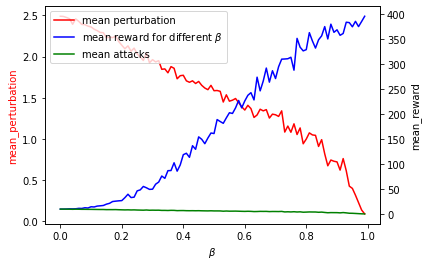

In [10]:
# Plot result

from matplotlib import pyplot as plt


fig, ax1 = plt.subplots()

ax1.set_xlabel('$\\beta$')
ax1.set_ylabel('mean_perturbation', color='red')
plot1, = ax1.plot(beta_data['beta'], beta_data['mean_perturbation'], color='red')

ax2 = ax1.twinx()
ax2.set_ylabel('mean_reward', color='black')
plot2, = ax2.plot(beta_data['beta'], beta_data['mean_reward'], color='blue')
plot3, = ax2.plot(beta_data['beta'], beta_data['mean_attacks'], color='green')

plt.legend(
    [plot1, plot2, plot3], 
    ['mean perturbation', 'mean reward for different $\\beta$', 'mean attacks']
    )
plt.show()

In [ ]:
# Evaluate model - for info on why the env is wrapped with Monitor check the evaluate_policy function
mean_reward, std_reward = evaluate_policy(model, Monitor(env), n_eval_episodes=100)
print(f"mean_reward : {mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward : 483.20 +/- 32.36


In [13]:
# Test uniform attack with optimized parameters

num_episodes = 100
all_episodes_rewards = []
all_episodes_perturbation = []

for i in range(num_episodes):
    episode_rewards = []
    episode_perturbations = []
    done = False
    obs = env.reset()

    timestep = 0
    
    while not done:

        timestep += 1

        ### strategically timed attack ###
        adversarial_sample, perturbation, attacks = strategically_timed_attack.perturb(env, obs, (0.0, 0.0, 0.5, 0.5), 0.45)
        ### strategically timed attack ###        
        
        action, _states = model.predict(adversarial_sample)
        obs, reward, done, info = env.step(action)
        episode_rewards.append(reward)
        episode_perturbations.append(perturbation)

    all_episodes_rewards.append(sum(episode_rewards))
    all_episodes_perturbation.append(sum(episode_perturbations) / timestep)

print(f"Finished!")
print(f"Final mean reward: {np.mean(all_episodes_rewards):.2f}")
print(f"Mean perturbation: {np.mean(all_episodes_perturbation):.2f}")
print(f"Mean attacks: {np.mean(all_episodes_attacks):.2f}")
print(f"Num episodes: {num_episodes}")

Finished!
Final mean reward: 125.17
Mean perturbation: 0.02
Mean attacks: 0.35
Num episodes: 100
